<a href="https://colab.research.google.com/github/Jaquelinedops/Benchmarking_NER/blob/main/Benchmarking_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install seqeval

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from seqeval.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from collections import Counter
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Is CUDA available?:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Total VRAM:", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2), "GB")
else:
    print("CUDA not available. GPU not detected.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Is CUDA available?: True
GPU Name: Tesla T4
Total VRAM: 14.74 GB
Using device: cuda


In [4]:
# --- Seção 1: Baixando a base e definindo modelos para benchmark ---

# carregando o conll2003 dataset
try:
    dataset_tfds, info = tfds.load(
        "conll2003",
        split='test',
        as_supervised=False,
        with_info=True
    )
    test_ds = dataset_tfds
    label_list = info.features['ner'].feature.names
    print("Dataset 'conll2003' loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Dicionário de modelos para o benchmark
modelos = {
    "XML-RoBERTa": "Davlan/xlm-roberta-base-ner-hrl",
    "BERT-Davlan": "Davlan/bert-base-multilingual-cased-ner-hrl",
    "BERT": "dslim/bert-base-NER",
    #"RoBERTa": "Jean-Baptiste/roberta-large-ner-english",
}

# --- Seção 2: Função para Avaliação ---

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from seqeval.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
import time
from tqdm import tqdm
import numpy as np
def avaliar_modelo_ner(model_name, dataset_para_teste, label_list, device):
    """
    Carrega um modelo e seu tokenizer, roda o pipeline de NER no dataset de teste
    e retorna um relatório de classificação detalhado incluindo o score Cohen's Kappa,
    o Kappa por tag, e o tempo total de inferência.
    """
    print(f"\n--- Avaliando o Modelo: {model_name} ---")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name).to(device)

    device_id = -1 if device == 'cpu' else 0
    ner_pipeline = pipeline(
        "ner",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="simple",
        device=device_id
    )

    verdades_seqeval = []
    predicoes_seqeval = []
    verdades_flattened = []
    predicoes_flattened = []

    start_time = time.time()

    for exemplo in tqdm(dataset_para_teste, desc=f"Avaliando {model_name}"):
        tokens = [t.decode('utf-8') for t in exemplo['tokens'].numpy().tolist()]
        tags_verdadeiras_ids = exemplo['ner'].numpy().tolist()
        tags_verdadeiras_str = [label_list[tag_id] for tag_id in tags_verdadeiras_ids]

        texto = " ".join(tokens)
        preds = ner_pipeline(texto)

        preds_seq_level = ['O'] * len(tokens)
        preds_kappa_level = ['O'] * len(tokens)

        current_char_idx = 0
        for pred in preds:
            word = pred['word']
            entity_type = pred['entity_group']

            token_start_index = -1
            temp_text = ""
            for i, token in enumerate(tokens):
                if word.startswith(temp_text + token):
                    if token_start_index == -1:
                        token_start_index = i
                    temp_text += token
                    if temp_text == word:
                        break
                else:
                    temp_text = ""
                    token_start_index = -1

            if token_start_index != -1:
                preds_seq_level[token_start_index] = f"B-{entity_type}"
                preds_kappa_level[token_start_index] = f"B-{entity_type}"
                for i in range(token_start_index + 1, len(tokens)):
                    if word.endswith("".join(tokens[token_start_index:i+1])):
                        preds_seq_level[i] = f"I-{entity_type}"
                        preds_kappa_level[i] = f"I-{entity_type}"
                    else:
                        break

        verdades_seqeval.append(tags_verdadeiras_str)
        predicoes_seqeval.append(preds_seq_level)

        verdades_flattened.extend(tags_verdadeiras_str)
        predicoes_flattened.extend(preds_kappa_level)

    end_time = time.time()
    tempo_total = end_time - start_time

    print(f"\nTempo total de inferência: {tempo_total:.2f} segundos")

    relatorio = classification_report(verdades_seqeval, predicoes_seqeval, digits=5, output_dict=True)
    kappa_global = cohen_kappa_score(verdades_flattened, predicoes_flattened)

    tags_para_kappa = ['ORG', 'PER', 'LOC', 'MISC']

    kappa_por_tag = {}
    for tag in tags_para_kappa:
        y_true_binary = [1 if t.endswith(tag) else 0 for t in verdades_flattened]
        y_pred_binary = [1 if p.endswith(tag) else 0 for p in predicoes_flattened]

        if sum(y_true_binary) > 0 or sum(y_pred_binary) > 0:
             kappa_por_tag[tag] = cohen_kappa_score(y_true_binary, y_pred_binary)
        else:
             kappa_por_tag[tag] = 0.0

    return relatorio, kappa_global, kappa_por_tag, tempo_total

# --- Seção 3: Execução do Benchmark e Exibição dos Resultados ---

# Detectar o dispositivo disponível (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
relatorio_final = {}

for nome_modelo, model_id in modelos.items():
    relatorio_dict, kappa_global, kappa_por_tag, tempo_inferencia = avaliar_modelo_ner(model_id, test_ds, label_list, device)

    # Adiciona a nova métrica 'kappa_score' aos dicionários de cada tag
    for tag, kappa_val in kappa_por_tag.items():
        if tag in relatorio_dict:
            relatorio_dict[tag]['kappa_score'] = round(kappa_val, 4)

    supports = [relatorio_dict[tag]['support'] for tag in kappa_por_tag]
    kappa_values = list(kappa_por_tag.values())

    macro_kappa = np.mean(kappa_values)
    weighted_kappa = np.average(kappa_values, weights=supports)

    if 'macro avg' in relatorio_dict:
        relatorio_dict['macro avg']['kappa_score'] = round(macro_kappa, 4)
    if 'weighted avg' in relatorio_dict:
        relatorio_dict['weighted avg']['kappa_score'] = round(weighted_kappa, 4)

    # Cria o DataFrame a partir do dicionário modificado, agora incluindo as médias
    df_relatorio_modelo = pd.DataFrame(relatorio_dict).transpose()
    df_relatorio_modelo = df_relatorio_modelo.round(4)

    relatorio_final[nome_modelo] = {
        'relatorio': relatorio_dict,
        'kappa_por_tag': kappa_por_tag,
        'tempo_inferencia': tempo_inferencia
    }

    print(f"\n{'='*70}")
    print(f"RELATÓRIO DE AVALIAÇÃO PARA O MODELO: {nome_modelo}")
    print('KAPPA GLOBAL ', kappa_global)
    print('tempo_inferencia ', tempo_inferencia)
    print('='*70)
    print(df_relatorio_modelo)
    print(f"\n{'='*70}\n")

Dataset 'conll2003' loaded successfully.
Using device: cuda

--- Avaliando o Modelo: Davlan/xlm-roberta-base-ner-hrl ---


Device set to use cuda:0
Avaliando Davlan/xlm-roberta-base-ner-hrl: 100%|██████████| 3454/3454 [02:22<00:00, 24.30it/s]



Tempo total de inferência: 142.17 segundos

RELATÓRIO DE AVALIAÇÃO PARA O MODELO: XML-RoBERTa
KAPPA GLOBAL  0.45472769108251687
tempo_inferencia  142.17483401298523
              precision  recall  f1-score  support  kappa_score
LOC              0.9578  0.7614    0.8484   1668.0       0.7736
MISC             0.0000  0.0000    0.0000    702.0       0.0000
ORG              0.8925  0.5250    0.6611   1661.0       0.4884
PER              0.9202  0.2566    0.4014   1617.0       0.2467
micro avg        0.9285  0.4527    0.6087   5648.0          NaN
macro avg        0.6926  0.3858    0.4777   5648.0       0.3772
weighted avg     0.8088  0.4527    0.5599   5648.0       0.4427



--- Avaliando o Modelo: Davlan/bert-base-multilingual-cased-ner-hrl ---


Device set to use cuda:0
Avaliando Davlan/bert-base-multilingual-cased-ner-hrl: 100%|██████████| 3454/3454 [00:46<00:00, 74.77it/s]



Tempo total de inferência: 46.20 segundos

RELATÓRIO DE AVALIAÇÃO PARA O MODELO: BERT-Davlan
KAPPA GLOBAL  0.46880636746021687
tempo_inferencia  46.196170806884766
              precision  recall  f1-score  support  kappa_score
LOC              0.9432  0.7560    0.8393   1668.0       0.7671
MISC             0.0000  0.0000    0.0000    702.0       0.0000
ORG              0.8874  0.5647    0.6902   1661.0       0.5194
PER              0.9367  0.2746    0.4247   1617.0       0.2631
micro avg        0.9215  0.4680    0.6207   5648.0          NaN
macro avg        0.6918  0.3988    0.4885   5648.0       0.3874
weighted avg     0.8077  0.4680    0.5724   5648.0       0.4546



--- Avaliando o Modelo: dslim/bert-base-NER ---


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Avaliando dslim/bert-base-NER: 100%|██████████| 3454/3454 [00:39<00:00, 87.76it/s]



Tempo total de inferência: 39.36 segundos

RELATÓRIO DE AVALIAÇÃO PARA O MODELO: BERT
KAPPA GLOBAL  0.4692888742107534
tempo_inferencia  39.358927965164185
              precision  recall  f1-score  support  kappa_score
LOC              0.9457  0.6781    0.7898   1668.0       0.7181
MISC             0.8665  0.5271    0.6554    702.0       0.5520
ORG              0.8927  0.5111    0.6501   1661.0       0.4825
PER              0.9425  0.1824    0.3057   1617.0       0.1839
micro avg        0.9162  0.4683    0.6198   5648.0          NaN
macro avg        0.9118  0.4747    0.6003   5648.0       0.4841
weighted avg     0.9194  0.4683    0.5934   5648.0       0.4752




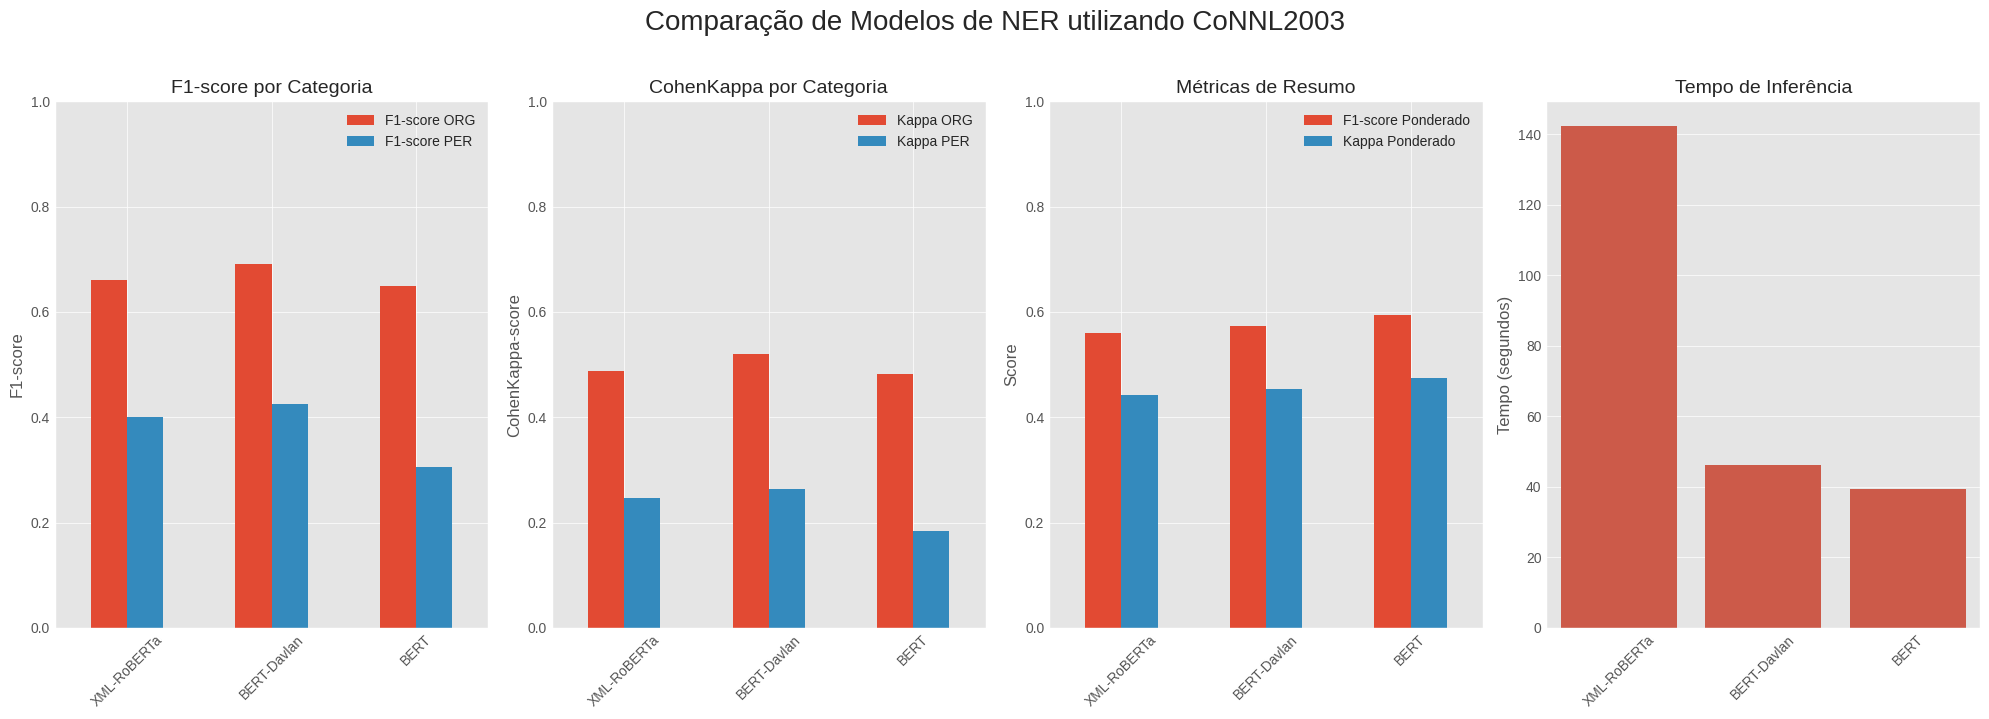

In [22]:
# --- Seção 4: Visualização dos resultados ---
import matplotlib.pyplot as plt
import seaborn as sns
def visualizar_comparacao_modelos(relatorio_final, dataset_name: str = 'Não informado'):
    """
    Gera gráficos de comparação para as métricas de desempenho dos modelos.

    Args:
        relatorio_final (dict): Dicionário contendo os resultados de avaliação de cada modelo.
    """
    if not relatorio_final:
        print("Erro: O dicionário de relatório está vazio.")
        return

    # --- 1. Preparação dos Dados para o DataFrame ---
    lista_para_df = []

    for nome_modelo, resultados in relatorio_final.items():
        relatorio = resultados['relatorio']
        kappa_por_tag = resultados['kappa_por_tag']
        tempo = resultados['tempo_inferencia']

        # Extrai as métricas de F1-score para as tags de interesse
        f1_org = relatorio.get('ORG', {}).get('f1-score', np.nan)
        f1_per = relatorio.get('PER', {}).get('f1-score', np.nan)
        kappa_org = relatorio.get('ORG', {}).get('kappa_score', np.nan)
        kappa_per = relatorio.get('PER', {}).get('kappa_score', np.nan)

        # Extrai as métricas de resumo
        f1_weighted = relatorio.get('weighted avg', {}).get('f1-score', np.nan)
        kappa_weighted = relatorio.get('weighted avg', {}).get('kappa_score', np.nan)

        lista_para_df.append({
            'modelo': nome_modelo,
            'F1-score ORG': f1_org,
            'F1-score PER': f1_per,
            'Kappa ORG': kappa_org,
            'Kappa PER': kappa_per,
            'F1-score Ponderado': f1_weighted,
            'Kappa Ponderado': kappa_weighted,
            'Tempo de Inferência (s)': tempo
        })

    df_comparacao = pd.DataFrame(lista_para_df)

    # --- 2. Geração dos Gráficos ---
    #plt.style.use('bmh')
    plt.style.use('ggplot')


    fig, axes = plt.subplots(1, 4, figsize=(20, 7))
    fig.suptitle('Comparação de Modelos de NER utilizando '+ dataset_name, fontsize=20, y=1.02)

    # Gráfico 1: F1-score por tag específica
    df_comparacao.set_index('modelo')[['F1-score ORG', 'F1-score PER']].plot(kind='bar', ax=axes[0])
    axes[0].set_title('F1-score por Categoria', fontsize=14)
    axes[0].set_ylabel('F1-score')
    axes[0].set_xlabel('')
    axes[0].set_ylim(0, 1.0)
    axes[0].tick_params(axis='x', rotation=45)

    # Gráfico 2: CohenKappa por tag específica
    df_comparacao.set_index('modelo')[['Kappa ORG', 'Kappa PER']].plot(kind='bar', ax=axes[1])
    axes[1].set_title('CohenKappa por Categoria', fontsize=14)
    axes[1].set_ylabel('CohenKappa-score')
    axes[1].set_xlabel('')
    axes[1].set_ylim(0, 1.0)
    axes[1].tick_params(axis='x', rotation=45)

    # Gráfico 3: Métricas
    df_comparacao.set_index('modelo')[['F1-score Ponderado', 'Kappa Ponderado']].plot(kind='bar', ax=axes[2])
    axes[2].set_title('Métricas de Resumo', fontsize=14)
    axes[2].set_ylabel('Score')
    axes[2].set_xlabel('')
    axes[2].set_ylim(0, 1.0)
    axes[2].tick_params(axis='x', rotation=45)

    # Gráfico 4: Tempo de Inferência
    sns.barplot(x='modelo', y='Tempo de Inferência (s)', data=df_comparacao, ax=axes[3])
    axes[3].set_title('Tempo de Inferência', fontsize=14)
    axes[3].set_ylabel('Tempo (segundos)')
    axes[3].set_xlabel('')
    axes[3].tick_params(axis='x', rotation=45)



    plt.tight_layout()
    plt.show()


visualizar_comparacao_modelos(relatorio_final, "CoNNL2003" )